In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from rfgap import RFGAP
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier

import sys
sys.path.append("SupportFunctions")  # Add subdirectory to Python's path

from prepare_datasets import DatasetPreprocessor  # Import from the .py file



In [60]:
##attempt number 3
def RFoversample(Data, target_ind=0, num_samples=3, contains_categoricals=False, encoded=False, cat_cols=None):
    numof_cat_cols = 0

    #make a dictionary with each categorical column and its unique values. This will be useful further down the line
    cat_dict = {}

    if not encoded:
        # If NOT encoded, store unique values for each categorical column
        for col in cat_cols:
            cat_dict[col] = Data[col].nunique()
            numof_cat_cols = len(cat_cols)
    else:
        # If encoded, infer categorical groups from one-hot encoded column names
        encoded_groups = {}
        for col in Data.columns:
            for cat_col in cat_cols:
                if col.startswith(cat_col + "_"):  # Check if the column belongs to a one-hot encoded group
                    encoded_groups[cat_col] = encoded_groups.get(cat_col, 0) + 1
                    numof_cat_cols += 1

        cat_dict = encoded_groups  # Store the grouped one-hot column names
        numof_num_cols = len(Data.columns) - numof_cat_cols - 1 #calculate number of numerical columns (-1 for target variable)

    x = None
    y = None

    if not encoded:    
        data_encoded = pd.get_dummies(Data, columns=cat_cols, dtype=int) #encode the categorical columns
        y = data_encoded.iloc[:, target_ind]
        x = data_encoded.drop(Data.columns[target_ind], axis=1)
    else:
        y = Data.iloc[:, target_ind]
        x = Data.drop(Data.columns[target_ind], axis=1)

    #Train RF, get proximities
    rf = RFGAP(y = y, prediction_type = 'classification', matrix_type = 'dense')
    rf.fit(x, y)
    prox = rf.get_proximities()

    #Get the Majority Class, its count, and store all classes and their counts in a dictionary. This will be useful further down the line
    value_counts = y.value_counts()
    maj_label = value_counts.index[0]
    maj_count = value_counts.iloc[0]
    class_counts = value_counts.to_dict()

    # Separate numerical and categorical data
    encoded_cat_cols = x.columns[numof_num_cols:]
    x_numerical = x.drop(columns=encoded_cat_cols)
    x_categorical = x[encoded_cat_cols] 

    #store number of features in each type
    num_features_size = x_numerical.shape[1]
    cat_features_size = x_categorical.shape[1]

    #Loop through all classes that aren't majority class and upsample
    for label in class_counts:
        if label != maj_label:

            #Get number of samples to upsample
            #initialize arrays to store new numerical and categorical features
            upsample_size = maj_count - class_counts[label]
            new_points_num = np.zeros((upsample_size, num_features_size))
            new_points_cat = np.zeros((upsample_size, cat_features_size), dtype=int)

            #generate new samples until the number of samples is equal to the majority class
            for i in range(upsample_size):

                #sample random points from the class that needs to be upsampled
                sample_indices = np.where(y == label)[0]
                samples = np.random.choice(sample_indices, num_samples, replace=True)

                #Get new numerical features and add to new points array
                new_features_num = np.sum((x_numerical.T.iloc[:, samples] @ prox[samples, :]), axis=1)/num_samples #proximity weighted average of the samples
                new_points_num[i, : ] = new_features_num

                #Get new categorical features and add to new points array
                start_x_slice_ind = 0 #variable to help in slicing categorical columns to focus on one encoded categorical feature at a time
                for categorical_feature in cat_dict: #loop through the features in the encoded x_categorical columns

                    numof_values_in_feature = cat_dict[categorical_feature] #number of columns in x_categorical dedicated to specified encoded feature - used in slicing
                    end_x_slice_ind = numof_values_in_feature + start_x_slice_ind
                    this_encoded_feature = x_categorical.iloc[:, start_x_slice_ind:end_x_slice_ind] #slice to focus on the encoded columns of a feature, one feature at a time

                    new_feature_cat_ind = np.sum((this_encoded_feature.T.iloc[:, samples] @ prox[samples, :]).T, axis=0).argmax(axis=0) #proximity weighted 'best guess' of the samples

                    #loop through the columns of the encoded feature and set the column with the highest proximity to 1 and the rest to 0
                    for j in range(numof_values_in_feature): 
                        if j == new_feature_cat_ind:
                                new_points_cat[i, j + start_x_slice_ind] = 1
                        else:
                                new_points_cat[i, j + start_x_slice_ind] = 0
                    start_x_slice_ind = end_x_slice_ind #update starting index for slicing

            #concatenate the new numerical and categorical features to the original data
            if not encoded:
                new_points_cat_non_dummy = pd.from_dummies(pd.DataFrame(new_points_cat, columns=x_categorical.columns), sep='_')
                new_combined_x = pd.concat((pd.DataFrame(new_points_num, columns=x_numerical.columns), 
                                            new_points_cat_non_dummy), axis=1)

                old_points_cat_non_dummy = pd.from_dummies(x_categorical, sep='_')
                old_combined_x = pd.concat((x_numerical, old_points_cat_non_dummy), axis=1)
            else:
                new_combined_x = pd.concat((pd.DataFrame(new_points_num, columns=x_numerical.columns), 
                                            pd.DataFrame(new_points_cat, columns=x_categorical.columns)), axis=1)
                old_combined_x = pd.concat((x_numerical, 
                                            x_categorical), axis=1)
            x = pd.concat((old_combined_x, 
                           new_combined_x), axis=0).reset_index(drop=True)
            y = pd.concat((y, 
                           pd.Series(np.ones_like(new_points_num[:, 0]) * label, 
                                     dtype=int))).reset_index(drop=True)

    return x, y

In [4]:
titanic = pd.read_csv('./datasets/titanic.csv')
titanic['Survived'].value_counts()

Survived
0    424
1    288
Name: count, dtype: int64

In [5]:
titanic_cat_cols = ['Pclass', 'Sex', 'Embarked']
new_x, new_y = RFoversample(titanic, contains_categoricals=True, cat_cols=titanic_cat_cols)

In [6]:
new_y.value_counts()

0    424
1    424
Name: count, dtype: int64

In [7]:
new_x.iloc[730: 750, :]

,Age,SibSp,Parch,Fare,Pclass,Sex,Embarked
730,31.333333,0.666667,0.000000,40.991667,1,male,S
731,33.000000,0.000000,0.000000,9.593067,3,female,S
732,23.000000,1.666667,0.666667,65.480567,1,female,S
733,17.000000,0.000000,1.666667,19.044433,2,female,S
734,27.333333,0.666667,0.333333,29.679167,2,male,S
735,22.333333,1.666667,0.666667,26.500000,2,female,S
736,43.000000,0.333333,0.000000,21.850000,2,female,S
737,24.000000,0.333333,0.333333,38.791667,3,female,S
738,8.250000,0.666667,0.333333,14.077767,3,female,S
739,25.666667,1.333333,0.666667,16.975000,1,female,S


In [8]:
new_y[730:750]

730    1
731    1
732    1
733    1
734    1
735    1
736    1
737    1
738    1
739    1
740    1
741    1
742    1
743    1
744    1
745    1
746    1
747    1
748    1
749    1
dtype: int64

Now Some Visualizations to Verify Function Correctly graphed points.

In [9]:
##attempt number 3
Data = titanic
target_ind = 0
num_samples = 3
cat_cols = titanic_cat_cols

numof_num_cols = len(Data.columns) - len(cat_cols) - 1 #calculate number of numerical columns (-1 for target variable)

#make a dictionary with each categorical column and its unique values. This will be useful further down the line
cat_dict = {}
for col in cat_cols:
    cat_dict[col] = Data[col].unique().tolist()
    
data_encoded = pd.get_dummies(Data, columns=cat_cols, dtype=int) #encode the categorical columns
y = data_encoded.iloc[:, target_ind]
x = data_encoded.drop(Data.columns[target_ind], axis=1)

#Train RF, get proximities
rf = RFGAP(y = y, prediction_type = 'classification', matrix_type = 'dense')
rf.fit(x, y)
prox = rf.get_proximities()

#Get the Majority Class, its count, and store all classes and their counts in a dictionary. This will be useful further down the line
value_counts = y.value_counts()
maj_label = value_counts.index[0]
maj_count = value_counts.iloc[0]
class_counts = value_counts.to_dict()

# Separate numerical and categorical data
encoded_cat_cols = x.columns[numof_num_cols:]
x_numerical = x.drop(columns=encoded_cat_cols)
x_categorical = x[encoded_cat_cols] 

#store number of features in each type
num_features_size = x_numerical.shape[1]
cat_features_size = x_categorical.shape[1]

#Loop through all classes that aren't majority class and upsample
for label in class_counts:
    if label != maj_label:

        #Get number of samples to upsample
        #initialize arrays to store new numerical and categorical features
        upsample_size = maj_count - class_counts[label]
        new_points_num = np.zeros((upsample_size, num_features_size))
        new_points_cat = np.zeros((upsample_size, cat_features_size), dtype=int)

        #generate new samples until the number of samples is equal to the majority class
        for i in range(upsample_size):

            #sample random points from the class that needs to be upsampled
            sample_indices = np.where(y == label)[0]
            samples = np.random.choice(sample_indices, num_samples, replace=True)

            #Get new numerical features and add to new points array
            new_features_num = np.sum((x_numerical.T.iloc[:, samples] @ prox[samples, :]), axis=1)/num_samples #proximity weighted average of the samples
            new_points_num[i, : ] = new_features_num

            #Get new categorical features and add to new points array
            start_x_slice_ind = 0 #variable to help in slicing categorical columns to focus on one encoded categorical feature at a time
            for categorical_feature in cat_dict: #loop through the features in the encoded x_categorical columns

                numof_values_in_feature = len(cat_dict[categorical_feature]) #number of columns in x_categorical dedicated to specified encoded feature - used in slicing
                end_x_slice_ind = numof_values_in_feature + start_x_slice_ind
                this_encoded_feature = x_categorical.iloc[:, start_x_slice_ind:end_x_slice_ind] #slice to focus on the encoded columns of a feature, one feature at a time

                new_feature_cat_ind = np.sum((this_encoded_feature.T.iloc[:, samples] @ prox[samples, :]).T, axis=0).argmax(axis=0) #proximity weighted 'best guess' of the samples

                #loop through the columns of the encoded feature and set the column with the highest proximity to 1 and the rest to 0
                for j in range(numof_values_in_feature): 
                    if j == new_feature_cat_ind:
                            new_points_cat[i, j + start_x_slice_ind] = 1
                    else:
                            new_points_cat[i, j + start_x_slice_ind] = 0
                start_x_slice_ind = end_x_slice_ind #update starting index for slicing

        #concatenate the new numerical and categorical features to the original data
        new_points_cat_non_dummy = pd.from_dummies(pd.DataFrame(new_points_cat, columns=x_categorical.columns), sep='_')
        new_combined_x = pd.concat((pd.DataFrame(new_points_num, columns=x_numerical.columns), new_points_cat_non_dummy), axis=1)

        old_points_cat_non_dummy = pd.from_dummies(x_categorical, sep='_')
        old_combined_x = pd.concat((x_numerical, old_points_cat_non_dummy), axis=1)
        upsampled_x = pd.concat((old_combined_x, new_combined_x), axis=0).reset_index(drop=True)
        upsampled_y = pd.concat((y, pd.Series(np.ones_like(new_points_num[:, 0]) * label, dtype=int))).reset_index(drop=True)


In [10]:
upsampled_y.name = 'Survived'
upsampled_titanic = pd.concat((upsampled_y, upsampled_x), axis=1)
upsampled_titanic

,Survived,Age,SibSp,Parch,Fare,Pclass,Sex,Embarked
0,0,22.000000,1.000000,0.000000,7.250000,3,male,S
1,1,38.000000,1.000000,0.000000,71.283300,1,female,C
2,1,26.000000,0.000000,0.000000,7.925000,3,female,S
3,1,35.000000,1.000000,0.000000,53.100000,1,female,S
4,0,35.000000,0.000000,0.000000,8.050000,3,male,S
...,...,...,...,...,...,...,...,...
843,1,26.000000,0.000000,0.000000,9.391667,3,female,S
844,1,27.333333,0.333333,0.666667,38.719433,1,male,S
845,1,36.000000,0.333333,0.000000,12.625000,3,female,S
846,1,29.833333,0.000000,0.000000,18.666667,2,female,C


In [11]:
upsampled_titanic['Obs_type'] = 'Old'
upsampled_titanic.loc[712:, 'Obs_type'] = 'New'
upsampled_titanic.iloc[700:720]

,Survived,Age,SibSp,Parch,Fare,Pclass,Sex,Embarked,Obs_type
700,0,19.000000,0.000000,0.000000,7.895800,3,male,S,Old
701,1,56.000000,0.000000,1.000000,83.158300,1,female,C,Old
702,1,25.000000,0.000000,1.000000,26.000000,2,female,S,Old
703,0,33.000000,0.000000,0.000000,7.895800,3,male,S,Old
704,0,22.000000,0.000000,0.000000,10.516700,3,female,S,Old
705,0,28.000000,0.000000,0.000000,10.500000,2,male,S,Old
706,0,25.000000,0.000000,0.000000,7.050000,3,male,S,Old
707,0,39.000000,0.000000,5.000000,29.125000,3,female,Q,Old
708,0,27.000000,0.000000,0.000000,13.000000,2,male,S,Old
709,1,19.000000,0.000000,0.000000,30.000000,1,female,S,Old


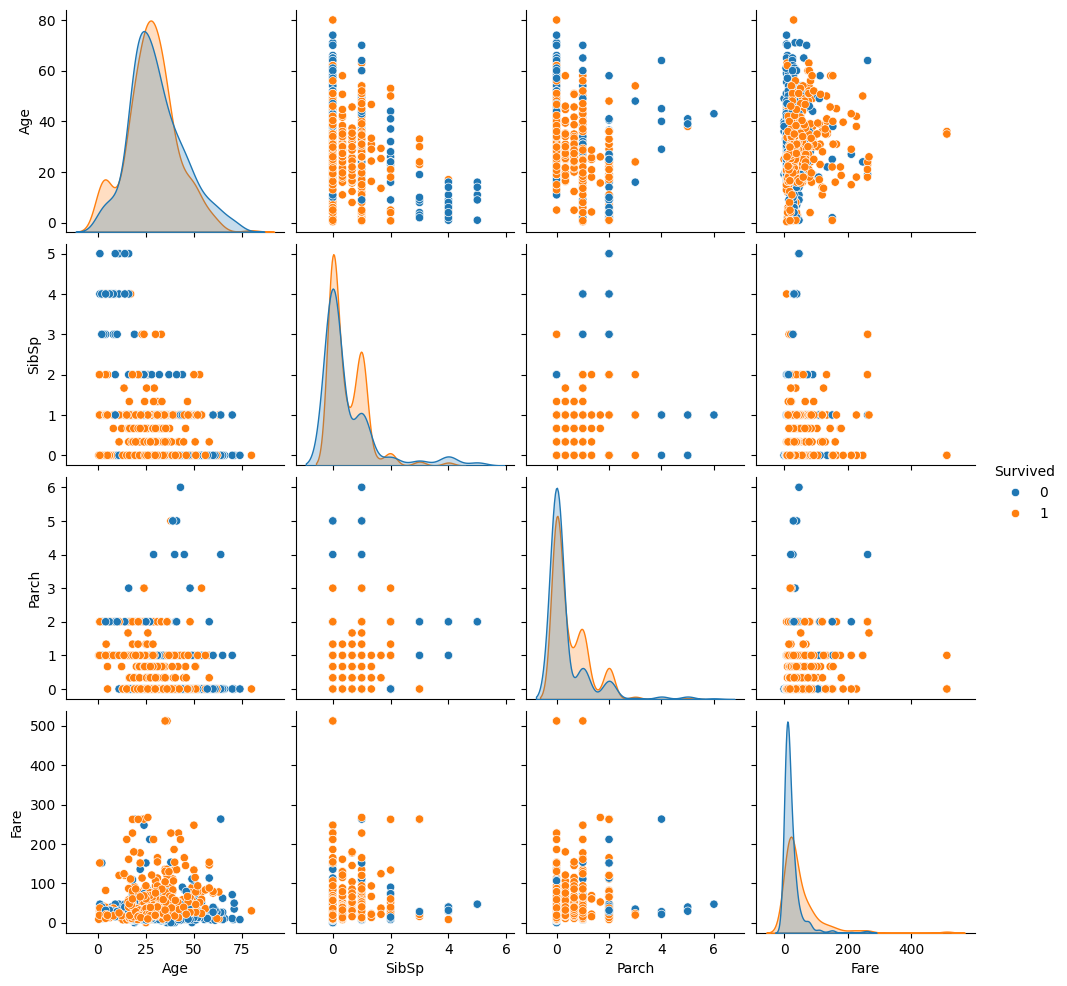

In [12]:
sns.pairplot(upsampled_titanic, hue='Survived')

<Axes: xlabel='Fare', ylabel='Age'>

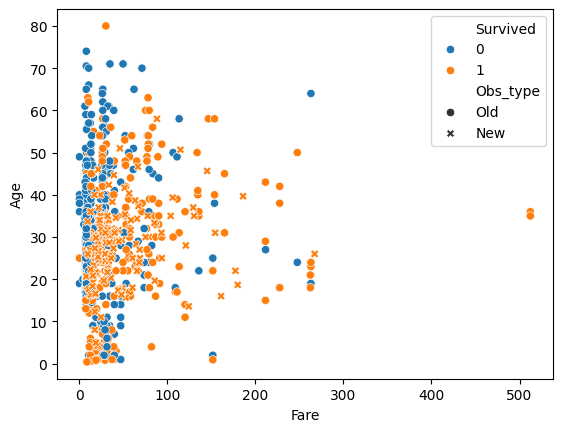

In [13]:
sns.scatterplot(upsampled_titanic, x='Fare', y='Age', hue='Survived', style='Obs_type')

COMPARE F1 SCORES

In [36]:
encoded_titanic = pd.get_dummies(titanic, columns=titanic_cat_cols, dtype=int)
preprocessor = DatasetPreprocessor(encoded_titanic, target_column='Survived')
x_train, y_train, x_test, y_test = (preprocessor.x_train, preprocessor.y_train,
                                    preprocessor.x_test, preprocessor.y_test)

Ordinal encoded categorical columns: []

Data Preparation Complete
Train-Test Split: Train (498) | Test (214)
Feature Columns: 12 | Categorical Processed: 0



In [61]:
TrainData = pd.concat((y_train, x_train), axis=1)
upsampled_x_train, upsampled_y_train = RFoversample(Data=TrainData, target_ind=0, encoded=True, cat_cols=titanic_cat_cols)

In [66]:
def Compare_RF_F1scores(n, x_train, y_train, x_train_upsampled, y_train_upsampled, x_test, y_test):
    #split data
    f1_scores_original = np.zeros(n)
    f1_scores_original_bal = np.zeros(n)
    f1_scores_upsampled = np.zeros(n)
    for i in range(n):
        #train, fit, and predict original points
        original_RF = RandomForestClassifier()
        original_RF.fit(x_train, y_train)
        y_pred_original = original_RF.predict(x_test)

        #train, fit, and predict original points on weights=balanced
        original_RF = RandomForestClassifier(class_weight='balanced')
        original_RF.fit(x_train, y_train)
        y_pred_original_bal = original_RF.predict(x_test)

        #train, fit, and predict upsampled points
        upsampled_RF = RandomForestClassifier()
        upsampled_RF.fit(x_train_upsampled, y_train_upsampled)
        y_pred_upsampled = upsampled_RF.predict(x_test)
        #append f1 scores
        f1_scores_original[i] = f1_score(y_test, y_pred_original, average='binary')
        f1_scores_original_bal[i] = f1_score(y_test, y_pred_original_bal, average='binary')
        f1_scores_upsampled[i] = f1_score(y_test, y_pred_upsampled, average='binary')
    return f1_scores_original, f1_scores_original_bal, f1_scores_upsampled

    

In [69]:
scores_original, scores_original_bal, scores_upsampled = Compare_RF_F1scores(10, x_train, y_train, upsampled_x_train,
                                                                             upsampled_y_train, x_test, y_test)

[Text(0.5, 1.0, 'Upsampled Data')]

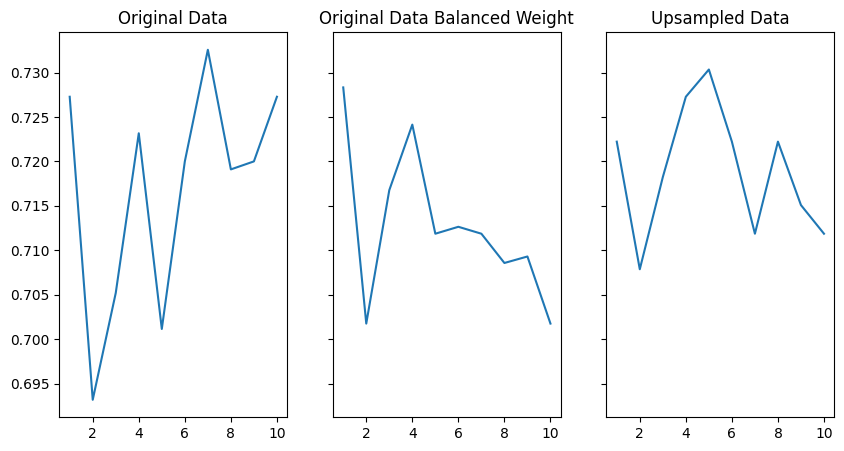

In [70]:
fig, ax = plt.subplots(1,3, figsize=(10,5), sharey=True)

ax[0].plot(range(1,11), scores_original)
ax[0].set(title='Original Data')
ax[1].plot(range(1,11), scores_original_bal)
ax[1].set(title='Original Data Balanced Weight')
ax[2].plot(range(1,11), scores_upsampled)
ax[2].set(title='Upsampled Data')